~Reproduce the LHV and Quantum value of CHSH [LHV=2 and Q=2*Sqrt(2)] 

~Programing the circuit in Qiskit to implement the CHSH inequality (with quantum gates)​ and testing the maximal violation in quantum computer

In [1]:
import qiskit

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService
service=QiskitRuntimeService(channel="ibm_quantum",
                             token='dd24e99cbbe3b083af54be876a6e40dd6bb8b95c0b9f17964427bcb4f9545a3d09c70556cd3b9070375914dbd811fe2cfb3fd5df3f22bd59176d4b7e924587cc')

In [38]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random
from qiskit import QuantumCircuit,transpile, assemble
import numpy as np
from qiskit_aer import Aer

Reproduce the LHV and Quantum value of CHSH [LHV=2 and Q=2*Sqrt(2)] 

In [39]:

# Function to create a circuit for a specific measurement setting
def create_chsh_circuit(theta_A, theta_B):
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.ry(-2 * theta_A, 0)
    qc.ry(-2 * theta_B, 1)
    qc.measure([0, 1], [0, 1])
    return qc

# Function to calculate the expectation value
def calculate_expectation(counts):
    total = sum(counts.values())
    expectation = 0
    for outcome, count in counts.items():
        parity = (-1) ** (int(outcome[0]) ^ int(outcome[1]))  # XOR of the bits
        expectation += parity * count / total
    return expectation

# Simulator
simulator = Aer.get_backend('qasm_simulator')

# Measurement angles for Alice and Bob
angles = {
    'a0b0': (0, np.pi/8),
    'a0b1': (0, -np.pi/8),
    'a1b0': (np.pi/4, np.pi/8),
    'a1b1': (np.pi/4, -np.pi/8)
}

# Execute the circuits and compute the expectation values
expectations = {}
for key, (theta_A, theta_B) in angles.items():
    qc = create_chsh_circuit(theta_A, theta_B)
    transpiled_qc = transpile(qc, simulator)
    result = simulator.run(transpiled_qc, shots=1024).result()  # Updated line
    counts = result.get_counts()
    expectations[key] = calculate_expectation(counts)

# Calculate the CHSH value
S = expectations['a0b0'] + expectations['a0b1'] + expectations['a1b0'] - expectations['a1b1']

print(f"CHSH Inequality and CHSH Game Results")
print(f"LHV Value (Classical Limit): 2")
print(f"Quantum Value (CHSH): {S} (should be close to {2 * np.sqrt(2)})")

# Output the expectation values and counts
for key in expectations:
    print(f"Expectation {key}: {expectations[key]}")


CHSH Inequality and CHSH Game Results
LHV Value (Classical Limit): 2
Quantum Value (CHSH): 2.82421875 (should be close to 2.8284271247461903)
Expectation a0b0: 0.703125
Expectation a0b1: 0.712890625
Expectation a1b0: 0.712890625
Expectation a1b1: -0.6953125


Programing the circuit in Qiskit to implement the CHSH inequality (with quantum gates)​ and testing the maximal violation in quantum computer

In [18]:
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Batch

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [19]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_sherbrooke'

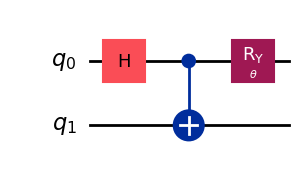

In [20]:
# Step 1: Map classical inputs to a quantum problem
# Create a parameterized CHSH circuit
theta = Parameter("$\\theta$")

chsh_circuit_no_meas = QuantumCircuit(2)
chsh_circuit_no_meas.h(0)
chsh_circuit_no_meas.cx(0, 1)
chsh_circuit_no_meas.ry(theta, 0)
chsh_circuit_no_meas.draw(output="mpl", idle_wires=False, style="iqp")

### Create a list of phase values to be assigned later

##After creating the parameterized CHSH circuit, we will create a list of phase values to be assigned to the circuit in the next step. We can create a list of 21 phase values range from $0$ to $2 \pi$ with equal spacing, that is, $0$, $0.1 \pi$, $0.2 \pi$, ..., $1.9 \pi$, $2 \pi$.


In [21]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases expressed as list of lists 
individual_phases = [[ph] for ph in phases]



Now we need observables from which to compute the expectation values.  In our case we are looking at orthogonal bases for each qubit, letting the parameterized $Y-$ rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables $ZZ$, $ZX$, $XZ$, and $XX$.


In [22]:
### Observables
ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZX = SparsePauliOp.from_list([("ZX", 1)])
XZ = SparsePauliOp.from_list([("XZ", 1)])
XX = SparsePauliOp.from_list([("XX", 1)])

ops = [ZZ, ZX, XZ, XX]
num_ops = len(ops)

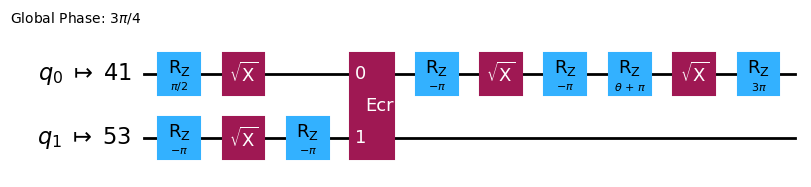

In [23]:
## Step 2: Optimize problem for quantum execution.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_ibm = pm.run(chsh_circuit_no_meas)
circuit_ibm.draw(output="mpl", idle_wires=False, style="iqp")

In [40]:
# Step 3: Execute using Qiskit Primitives.
batch_circuits = [circuit_ibm] * number_of_phases * num_ops
batch_ops = [op for op in ops for _ in individual_phases]

In [25]:
# Apply layout to the operator
circuit_ibm.num_qubits

127

However, we set up our operators for $2$ qubits, and they need expanding as well to match the number of qubits in the backend compliant circuit. The `SparsePauliOp` class in `Qiskit` has a nice utility method named `apply_layout()` to expand an operator. We simply query the `layout` attribute of the `circuit_ibm` and apply the layout to operators.


In [26]:
batch_ops[0].num_qubits

2

In [27]:
batch_ops_expanded = [op.apply_layout(layout=circuit_ibm.layout) for op in batch_ops]

In [28]:
batch_ops_expanded[0].num_qubits

127

In [29]:
# To run on a local simulator:

with Batch(backend=backend) as batch:
    estimator = Estimator()

    batch_expvals = (
        estimator.run(
            batch_circuits,
            batch_ops_expanded,
            parameter_values=individual_phases * num_ops,
            skip_transpilation=True,
            shots=10000,
        )
        .result()
        .values
    )

The individual expectation values can then be extracted from the batched results:


In [30]:
ZZ_expval, ZX_expval, XZ_expval, XX_expval = [
    batch_expvals[kk * number_of_phases : (kk + 1) * number_of_phases] for kk in range(num_ops)
]

In [31]:
# Step 4: Post-process, return result in classical format
# <CHSH1> = <AB> - <Ab> + <aB> + <ab>
chsh1_est = ZZ_expval - ZX_expval + XZ_expval + XX_expval

# <CHSH2> = <AB> + <Ab> - <aB> + <ab>
chsh2_est = ZZ_expval + ZX_expval - XZ_expval + XX_expval

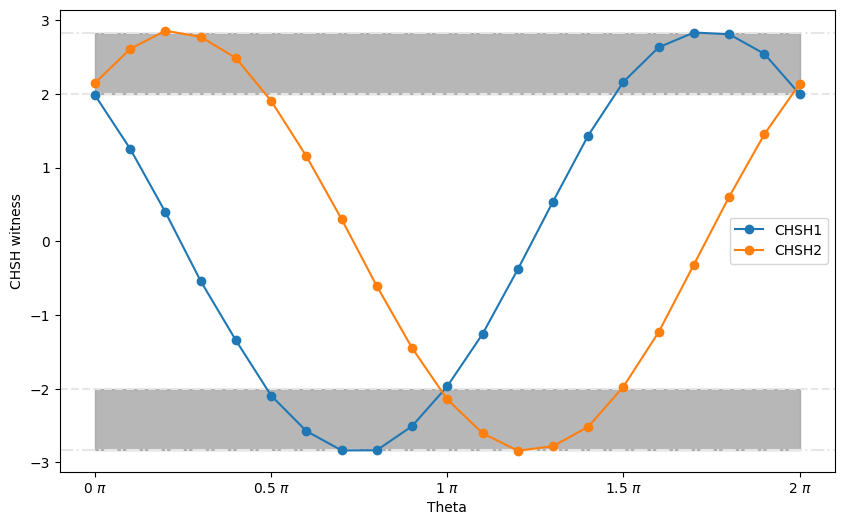

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

In the figure, the red dashed lines delimit the classical bounds ($\pm 2$) and the dash-dotted blue lines delimit the quantum bounds ($\pm 2\sqrt{2}$). We can see that the experimental results resemble the general trend of the simulated results and there are regions where the CHSH witness quantities exceeds the classical bounds. This demonstrated the violation of CHSH inequality in a real quantum system!
